In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy

import torch

from model import my_NN_model, MyDataset
from matplotlib.colors import LogNorm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opt:  Namespace(output_dir='./output', seed=12345, data_dir='../TNG_data', train_ratio=0.9, batch_size=1024, num_epochs=200, lr=0.0001, dropout=0.0, use_sampler=True, output_dim=50, hidden_dim=64, num_features_in=2, num_features_out=2, norm_params=[[11.0, 15.0], [-1.2, 3.0], [-2.0, 1.0], [-3.5, 3.5]])
JointDensityEstimator2D(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=2500, bias=True)
  )
  (last_activation): Softmax(dim=-1)
)


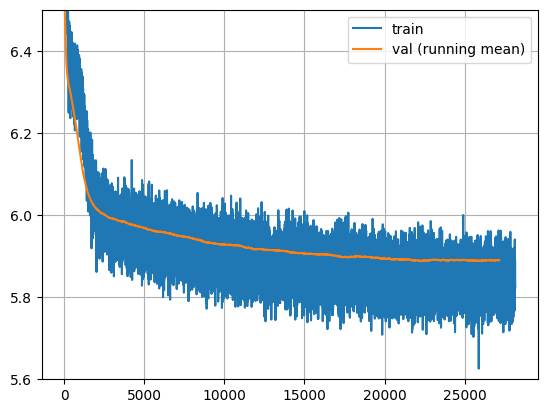

In [49]:
model_dir = "./output"

### plot loss 
loss = np.loadtxt(f"{model_dir}/log.txt", comments="#")
plt.figure()
plt.plot(loss[:,0], label="train")

def running_mean(x, window_size):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

loss_val = running_mean(loss[:,1], 1000)
xx = np.arange(len(loss_val)) 
plt.plot(xx, loss_val, label="val (running mean)")
plt.grid()
plt.legend()
#plt.yscale("log")
plt.ylim([5.6, 6.5])

### load parameters
with open(f"{model_dir}/args.json", "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.loadtxt("../norm_params.txt")

### load model
model = my_NN_model(opt)
model.to(device)

model.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model.eval()
print(model)

In [38]:
### True data ###
dataset_true = MyDataset(f"../TNG_data", norm_params=norm_params)
x_true = dataset_true.x
y_true = dataset_true.y

### model output ###
count = 0
generated = []
while count < len(x_true):
    tmp = x_true[count:count+opt.batch_size].to(device)
    gen, _ = model.generate(tmp)
    generated.append(gen)
    count += opt.batch_size
generated = torch.cat(generated, dim=0)

x_true = x_true.detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

In [39]:
### binning ###
nbins = 20
logm_bins = np.linspace(0, 1, nbins+1)
logm_bin_indices_true = np.digitize(x_true, logm_bins) - 1 # (num_samples,)

y_bins = np.linspace(0, 1, nbins+1)
y_bin_indices_true = np.digitize(y_true, y_bins) - 1 # (num_samples, seq_length, num_params)
y_bin_indices_generated = np.digitize(generated, y_bins) - 1 # (num_samples, seq_length, num_params)

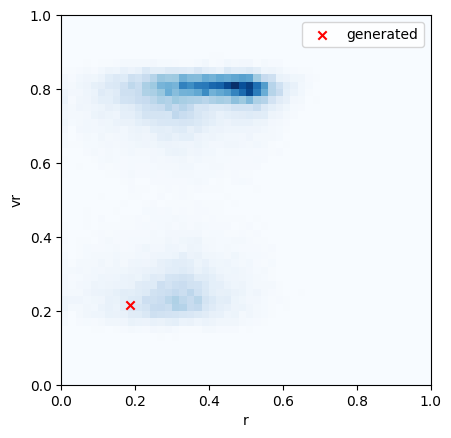

In [40]:
## Quick check of the output and probability
ibin = 5
nsample = 10
x_random = torch.rand(nsample, opt.num_features_in).to(device) 
x_random = x_random * (logm_bins[ibin+1] - logm_bins[ibin]) + logm_bins[ibin]
generated_test, prob = model.generate(x_random)
generated_test = generated_test.detach().cpu().numpy()
prob = prob.detach().cpu().numpy()

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10

for i, (x, g) in enumerate(zip(x_random, generated_test)):

    plt.figure()
    plt.imshow(prob[i].T, origin="lower", extent=[0, 1, 0, 1], aspect="equal", cmap="Blues")
    
    plt.scatter(g[0], g[1], marker="x", color="red", label="generated")
    plt.legend()

    plt.xlabel("r")
    plt.ylabel("vr")

    break


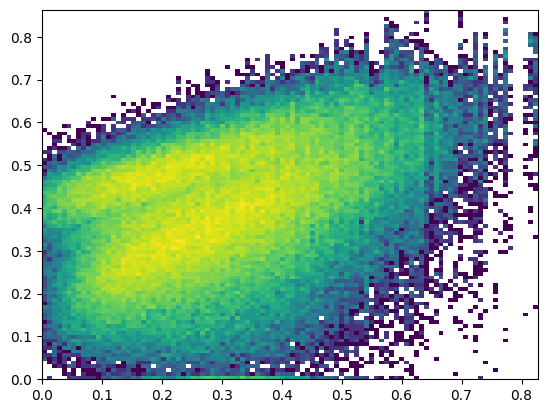

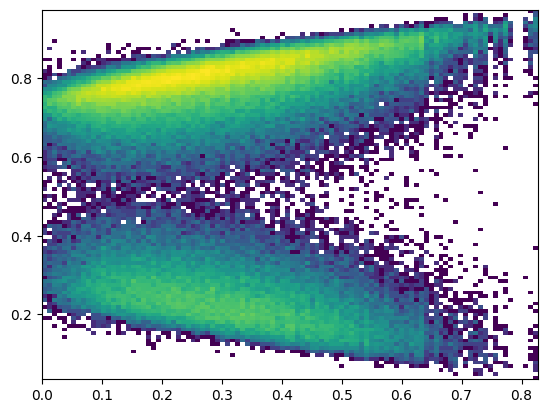

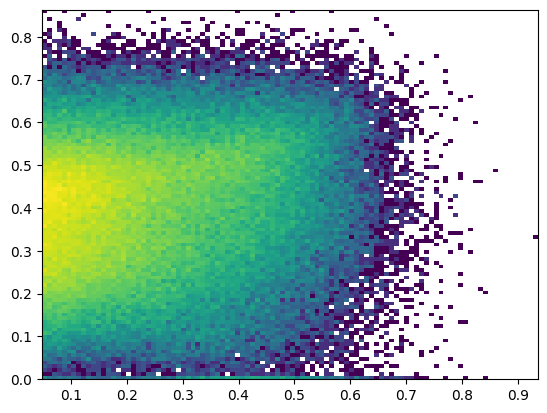

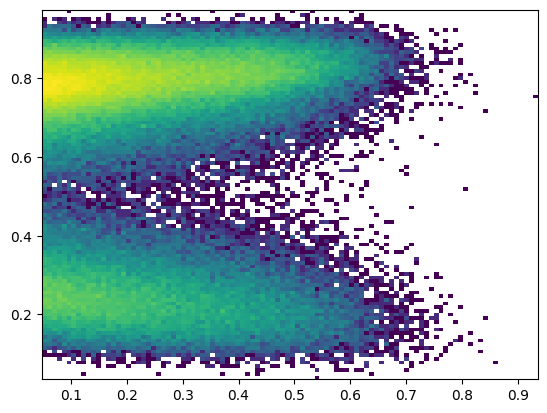

In [41]:
plt.figure()
hist2d = plt.hist2d(x_true[:,0], y_true[:,0], bins=100, norm=LogNorm())
#plt.scatter(x_true[:,0], generated[:,0], s=1)

plt.figure()
hist2d = plt.hist2d(x_true[:,0], y_true[:,1], bins=100, norm=LogNorm())
#plt.scatter(x_true[:,0], generated[:,1], s=1)

plt.figure()
hist2d = plt.hist2d(x_true[:,1], y_true[:,0], bins=100, norm=LogNorm())
#plt.scatter(x_true[:,1], generated[:,0], s=1)

plt.figure()
hist2d = plt.hist2d(x_true[:,1], y_true[:,1], bins=100, norm=LogNorm())
#plt.scatter(x_true[:,1], generated[:,1], s=1)
